# MODELO 3 - SVD , so com os ratings (usar kernel faa03)

# POR ACABAR !!!!!!!!!!

In [32]:
import pandas as pd
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import Reader, Dataset, SVD, accuracy
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

plt.rcParams.update({
    "text.usetex": True,              # If you want to use LaTeX fonts in text
    "font.family": "serif",           # IEEE uses Times New Roman-like fonts
    "font.size": 12,                   # General font size for IEEE format
    "axes.labelsize": 12,              # Axis labels font size
    "legend.fontsize": 11,             # Legend font size
    "xtick.labelsize": 11,             # X-axis tick labels font size
    "ytick.labelsize": 11,             # Y-axis tick labels font size
    "figure.figsize": (5, 5*0.8),
    "savefig.dpi": 300,               # DPI for high-quality PNG/JPEG
})

## Load the data and prepare it for the model

In [33]:
df_train = pd.read_csv("data/data_train.csv")
df_test = pd.read_csv("data/data_test.csv")

# train data
reader = Reader(rating_scale=(1, 5))
traindata = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']], reader)
trainset = traindata.build_full_trainset()

# test data
test_reader = Reader(rating_scale=(1, 5))
test_data = Dataset.load_from_df(df_test[['userId', 'movieId', 'rating']], test_reader)
testset = test_data.build_full_trainset().build_testset()

## Hyperparameter tunning with 8cv

In [ ]:
param_grid = {
    'n_factors': [50], #[50, 100, 150],        # Number of latent factors
    'lr_all':  [0.002], #[0.002, 0.005, 0.01],     # Learning rate
    'reg_all': [0.1], #[0.02, 0.1, 0.2]         # Regularization term
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=8)  # 8-fold cross-validation
gs.fit(traindata)

best_params = gs.best_params['rmse']
print("Best Hyperparameters:", best_params)

## Train the model with the best hyperparameters

In [26]:
best_algo = SVD(n_factors=best_params['n_factors'], 
                lr_all=best_params['lr_all'], 
                reg_all=best_params['reg_all'])
best_algo.fit(trainset)

## Results for the model

~~rmse~~, ~~mae~~, learning_curve, convergence, save the model

In [27]:
predictions_train = best_algo.test(trainset.build_testset())
predictions_test = best_algo.test(testset)

print(f"Train RMSE: {accuracy.rmse(predictions_train, verbose=False):.5f}")
print(f"Test RMSE: {accuracy.rmse(predictions_test, verbose=False):.5f}")
print("")
print(f"Train MAE: {accuracy.mae(predictions_train, verbose=False):.5f}")
print(f"Test MAE: {accuracy.mae(predictions_test, verbose=False):.5f}")

Train RMSE: 0.83996
Test RMSE: 0.89235

Train MAE: 0.64978
Test MAE: 0.68535


/opt/anaconda3/envs/FAA03/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


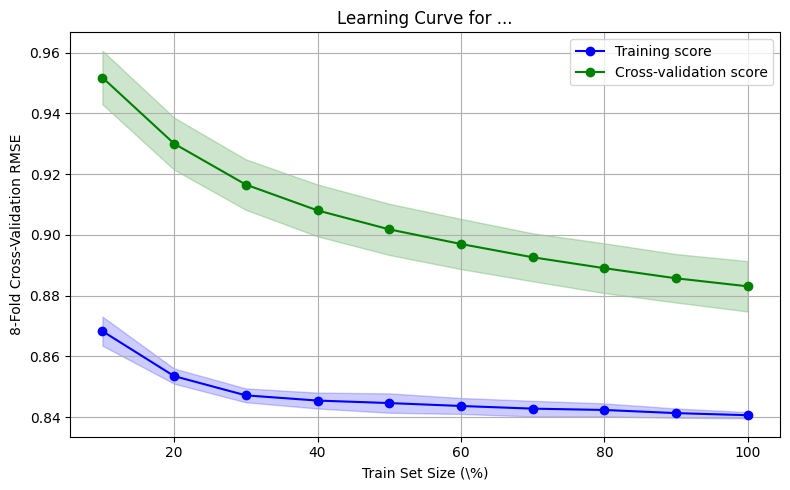

In [30]:
# learning curve with 8-fold cross-validation
df_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
folds = np.array_split(df_shuffled, 8)

dict_RMSE = {}
for fold in range(8):
    merged_df = pd.concat([part for i, part in enumerate(folds) if i != fold])

    for train_set_size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        merged_df_sized = merged_df.sample(frac=train_set_size, random_state=42)

        reader = Reader(rating_scale=(1, 5))
        traindata = Dataset.load_from_df(merged_df_sized[['userId', 'movieId', 'rating']], reader)
        trainset = traindata.build_full_trainset()
        best_algo.fit(trainset)

        #testset RMSE
        test_reader = Reader(rating_scale=(1, 5))
        test_data = Dataset.load_from_df(folds[fold][['userId', 'movieId', 'rating']], test_reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions_test = best_algo.test(testset)
        dict_RMSE[(fold, train_set_size, "test")] = accuracy.rmse(predictions_test, verbose=False)

        #trainset RMSE
        predictions_train = best_algo.test(trainset.build_testset())
        dict_RMSE[(fold, train_set_size, "train")] = accuracy.rmse(predictions_train, verbose=False)

# plot the learning curve
data = dict_RMSE

def plot_learning_curve(dataset):
    # Step 1: Group by j
    grouped_data = defaultdict(list)
    for (i, j, set), k in data.items():
        if set == dataset and j != 0:
            grouped_data[j].append(k)

    # Step 2: Calculate statistics
    mean_accuracy = []
    std_accuracy = []
    min_a = []
    max_a = []
    iterations = sorted(grouped_data.keys())  # Ensure ordered by j

    for j in iterations:
        values = grouped_data[j]
        mean_accuracy.append(np.mean(values))
        std_accuracy.append(np.std(values))
        min_a.append(np.min(values))
        max_a.append(np.max(values))

    # Step 3: Plot the curve with shaded area
    mean_accuracy = np.array(mean_accuracy)
    std_accuracy = np.array(std_accuracy)

    if dataset == "train":
        plt.plot(np.array(iterations)*100, mean_accuracy, "-o", label="Training score", color="blue")
        plt.fill_between(
            np.array(iterations)*100, 
            mean_accuracy - std_accuracy, 
            mean_accuracy + std_accuracy, 
            color="blue", alpha=0.2
        )
    else:
        plt.plot(np.array(iterations)*100, mean_accuracy, "-o", label="Cross-validation score", color="green")
        plt.fill_between(
            np.array(iterations)*100, 
            mean_accuracy - std_accuracy, 
            mean_accuracy + std_accuracy, 
            color="green", alpha=0.2
        )

plt.figure(figsize=(8, 5))
plot_learning_curve("train")
plot_learning_curve("test")
plt.xlabel(r"Train Set Size (\%)")
plt.ylabel("8-Fold Cross-Validation RMSE")
plt.title("Learning Curve for ... !!!!! AUSHDIUASHDIAHSD")
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig("assets/model03_learningcurve.png")
plt.show()


In [ ]:



# Step 4: Make predictions on the testset
predictions = best_algo.test(testset)



# Step 6: Optionally save predictions to a DataFrame for further analysis
predictions_df = pd.DataFrame([{
    'userId': pred.uid,
    'movieId': pred.iid,
    'true_rating': pred.r_ui,
    'predicted_rating': pred.est
} for pred in predictions])

print(predictions_df.head())
